Key Questions for This Project
1. What key factors contribute to a TikTok video becoming viral, and how can these factors be leveraged to optimize content strategy?
* This question helps you focus on the core features (e.g., engagement metrics, video duration, sentiment) that drive virality and understand their predictive power.

2. How can predictive models, such as Logistic Regression or Random Forest, be used to identify users who are at risk of disengagement or churn?
* This question emphasizes user retention by predicting churn, a critical issue for platforms like TikTok.

3. What business insights can be drawn from the AUC scores of
predictive models to ensure accuracy and reliability in decision-making processes?
* AUC helps evaluate model performance, allowing you to ensure predictions are meaningful and actionable for the business.

4. How can insights from sentiment analysis of video content help content creators improve engagement and user interaction on the platform?
* This question focuses on using text analysis (e.g., sentiment analysis) to drive actionable recommendations for content optimization.

5. How can TikTok’s advertising strategy be optimized using data-driven insights from ad campaign performance analysis?
* Optimizing ad campaigns based on historical data (e.g., impressions, click-through rate) is crucial for revenue generation and ROI improvements.


**Problem Statement**

TikTok is a global platform where users generate vast amounts of content daily. However, understanding what drives the virality of videos, identifying users who are at risk of disengagement, and optimizing ad campaigns remain challenges. In a fast-paced environment, actionable insights need to be derived from complex datasets to support the strategic goals of user retention, content virality, and revenue generation. This project aims to leverage advanced data analysis techniques—including machine learning models, feature engineering, and sentiment analysis—to predict viral content, identify churn, and optimize ad performance. The evaluation of these models will be measured through AUC scores to ensure their effectiveness and business impact. The ultimate goal is to provide TikTok’s teams with data-driven recommendations that will enhance platform engagement and user satisfaction.



In [3]:
# Data handling and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

# Natural language processing (optional, if text data is available)
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Display settings
import warnings
warnings.filterwarnings('ignore')


In [4]:
# Download the vader_lexicon resource
!pip install nltk # Make sure NLTK is installed
import nltk
nltk.download('vader_lexicon')

ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\varun\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### 2. Data Loading and Cleaning

2.1 Load Dataset and Inspect

In [7]:
# Load dataset
data = pd.read_csv("tiktok_dataset.csv")
# Display dataset info and check for missing values
print(data.info())

data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB
None


,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [8]:
print(data.isnull().sum())

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64


2.2 Handle Missing Values

In [10]:
# Fill missing values for numerical columns
numeric_columns = ['video_duration_sec', 'video_view_count', 'video_like_count', 'video_share_count', 'video_download_count', 'video_comment_count']
for column in numeric_columns:      # to acess columns
    data[column].fillna(data[column].median(), inplace=True)

# Drop rows where critical text or target fields (e.g., virality) are missing
data.dropna(subset=['video_transcription_text'], inplace=True)  #if this has null then complete drop

# Handling categorical columns (e.g., claim_status, verified_status, author_ban_status)
data['claim_status'].fillna('Unknown', inplace=True)
data['verified_status'].fillna('Unknown', inplace=True)
data['author_ban_status'].fillna('Unknown', inplace=True)

### 3. Feature Engineering

In [55]:
# Engagement ratios
data['like_to_view_ratio'] = data['video_like_count'] / data['video_view_count']
data['share_to_view_ratio'] = data['video_share_count'] / data['video_view_count']
data['comment_to_view_ratio'] = data['video_comment_count'] / data['video_view_count']

# Sentiment analysis on video transcription text
sid = SentimentIntensityAnalyzer()
data['sentiment_score'] = data['video_transcription_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,like_to_view_ratio,share_to_view_ratio,comment_to_view_ratio,sentiment_score,viral,churn
0,1,0,7017666017,59,someone shared with me that drone deliveries a...,0,2,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000702,0.000000,0.3400,0,0
1,2,0,4014381136,32,someone shared with me that there are more mic...,0,0,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.135111,0.004855,0.3818,0,0
2,3,0,9859838091,31,someone shared with me that american industria...,0,0,902185.0,97690.0,2858.0,833.0,329.0,0.108282,0.003168,0.000365,0.6369,1,0
3,4,0,1866847991,25,someone shared with me that the metro of st. p...,0,0,437506.0,239954.0,34812.0,1234.0,584.0,0.548459,0.079569,0.001335,0.3400,0,0
4,5,0,7105231098,19,someone shared with me that the number of busi...,0,0,56167.0,34987.0,4110.0,547.0,152.0,0.622910,0.073175,0.002706,0.4019,0,0


3.2 Label Encoding for Categorical Variables

In [63]:
# Encode categorical variables: claim_status, verified_status, author_ban_status these are yes or no type
#this is used to convert into 0's and 1's or maths format
label_encoders = {}
for column in ['claim_status', 'verified_status', 'author_ban_status']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,like_to_view_ratio,share_to_view_ratio,comment_to_view_ratio,sentiment_score,viral,churn
0,1,0,7017666017,59,someone shared with me that drone deliveries a...,0,2,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000702,0.000000,0.3400,0,0
1,2,0,4014381136,32,someone shared with me that there are more mic...,0,0,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.135111,0.004855,0.3818,0,0
2,3,0,9859838091,31,someone shared with me that american industria...,0,0,902185.0,97690.0,2858.0,833.0,329.0,0.108282,0.003168,0.000365,0.6369,1,0
3,4,0,1866847991,25,someone shared with me that the metro of st. p...,0,0,437506.0,239954.0,34812.0,1234.0,584.0,0.548459,0.079569,0.001335,0.3400,0,0
4,5,0,7105231098,19,someone shared with me that the number of busi...,0,0,56167.0,34987.0,4110.0,547.0,152.0,0.622910,0.073175,0.002706,0.4019,0,0


### 4. Handling Imbalanced Data
If virality prediction is the goal, and the viral videos are less frequent in the dataset, we can use SMOTE to handle the imbalance.

In [16]:
# Define features (X) and target (y)
X = data.drop(['video_id', 'video_view_count', 'video_like_count', 'video_transcription_text'], axis=1)  # Drop ID, unnecessary columns, and text column
y = (data['video_view_count'] > data['video_view_count'].quantile(0.9)).astype(int)  # Define 'viral' as top 10% views

# Handle imbalanced data using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Display resampled dataset shape
print(f"Original dataset shape: {X.shape}")
print(f"Resampled dataset shape: {X_resampled.shape}")

Original dataset shape: (19084, 12)
Resampled dataset shape: (34350, 12)


### 5. Exploratory Data Analysis (EDA)

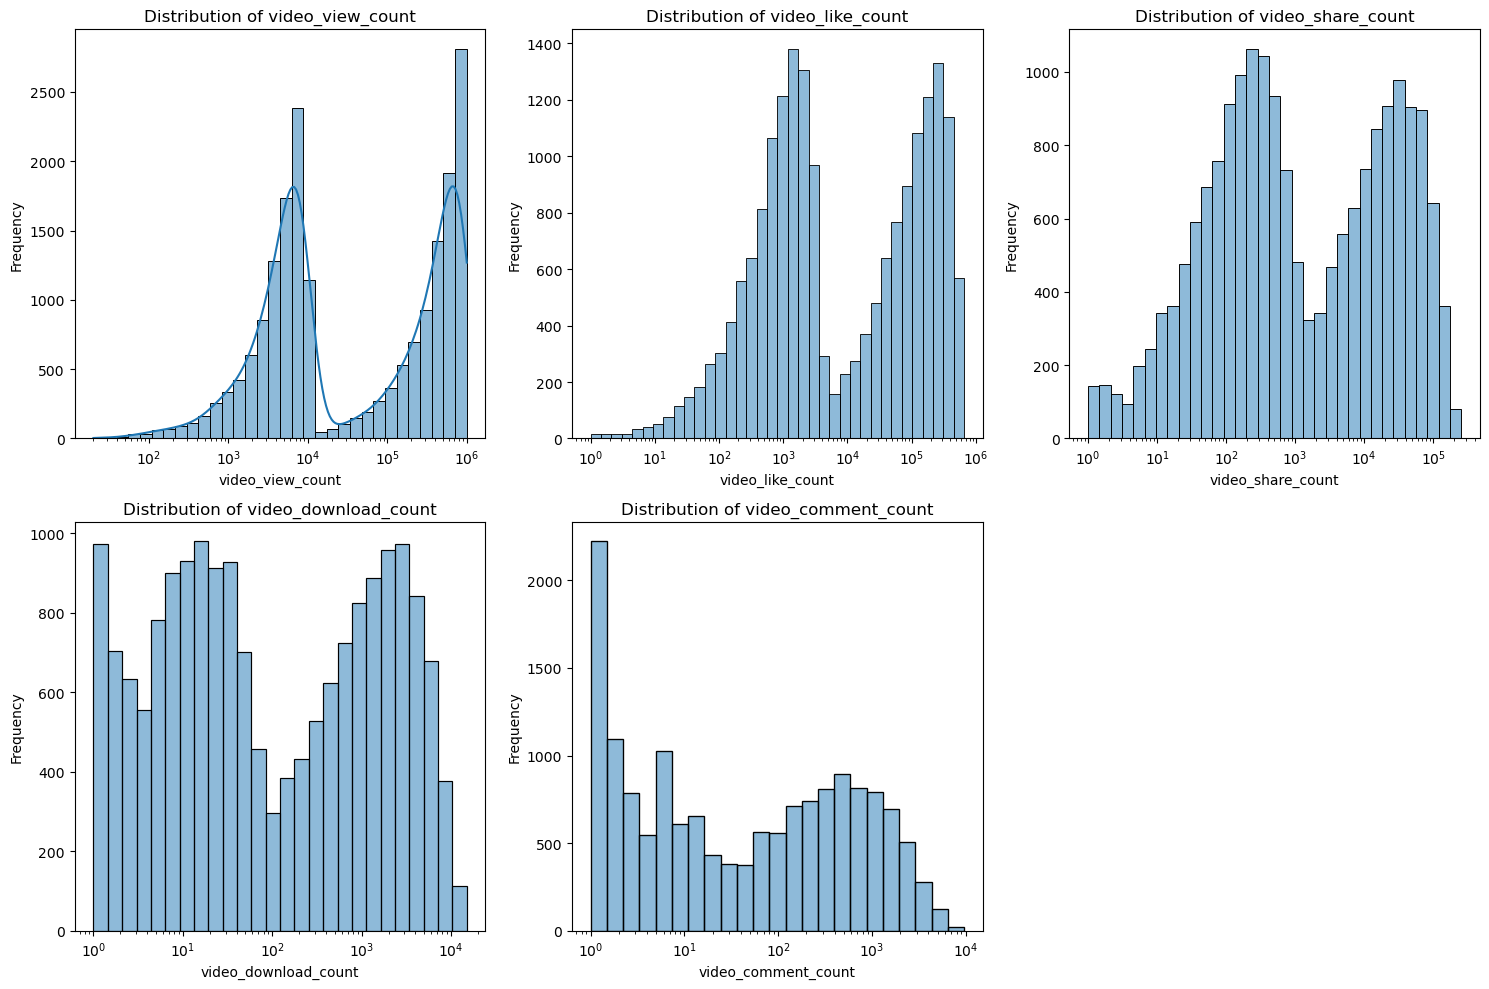

In [18]:
# Plot the distribution of key engagement metrics with log scaling (if necessary)
plt.figure(figsize=(15, 10))

# List of features to visualize
engagement_metrics = ['video_view_count', 'video_like_count', 'video_share_count', 'video_download_count', 'video_comment_count']

# Loop through and plot the histograms with logarithmic scaling
for i, feature in enumerate(engagement_metrics):
    plt.subplot(2, 3, i+1)
    sns.histplot(data[feature], kde=True, log_scale=(True, False))  # log scale for x-axis
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


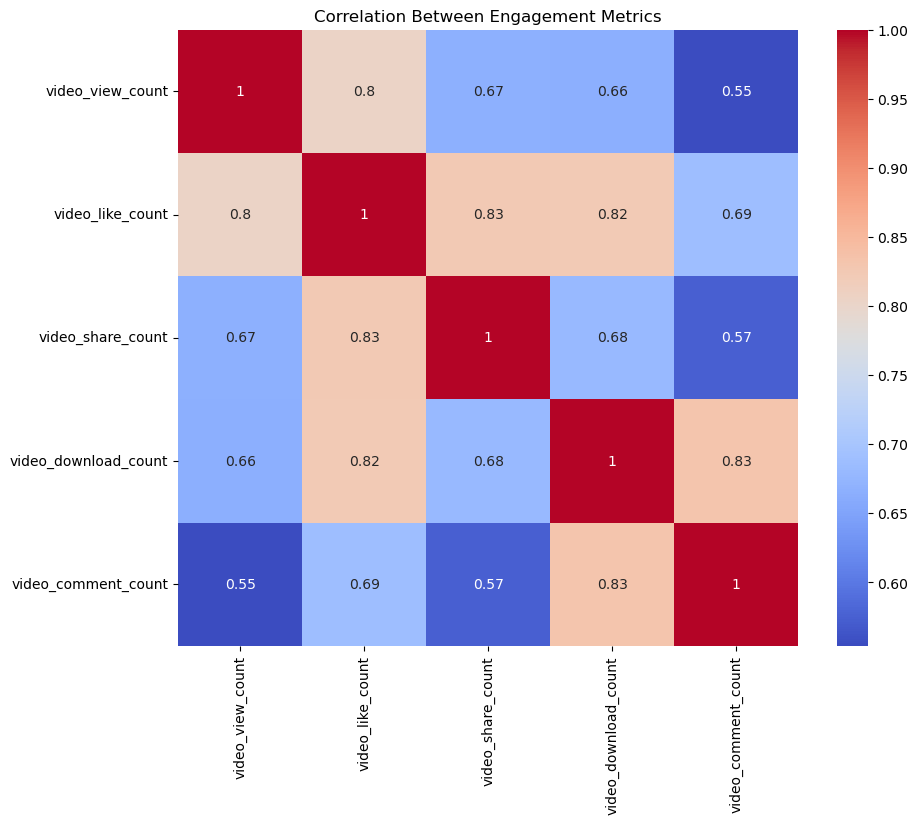

In [19]:
# Correlation heatmap of engagement metrics
plt.figure(figsize=(10, 8))
corr = data[engagement_metrics].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Between Engagement Metrics')
plt.show()


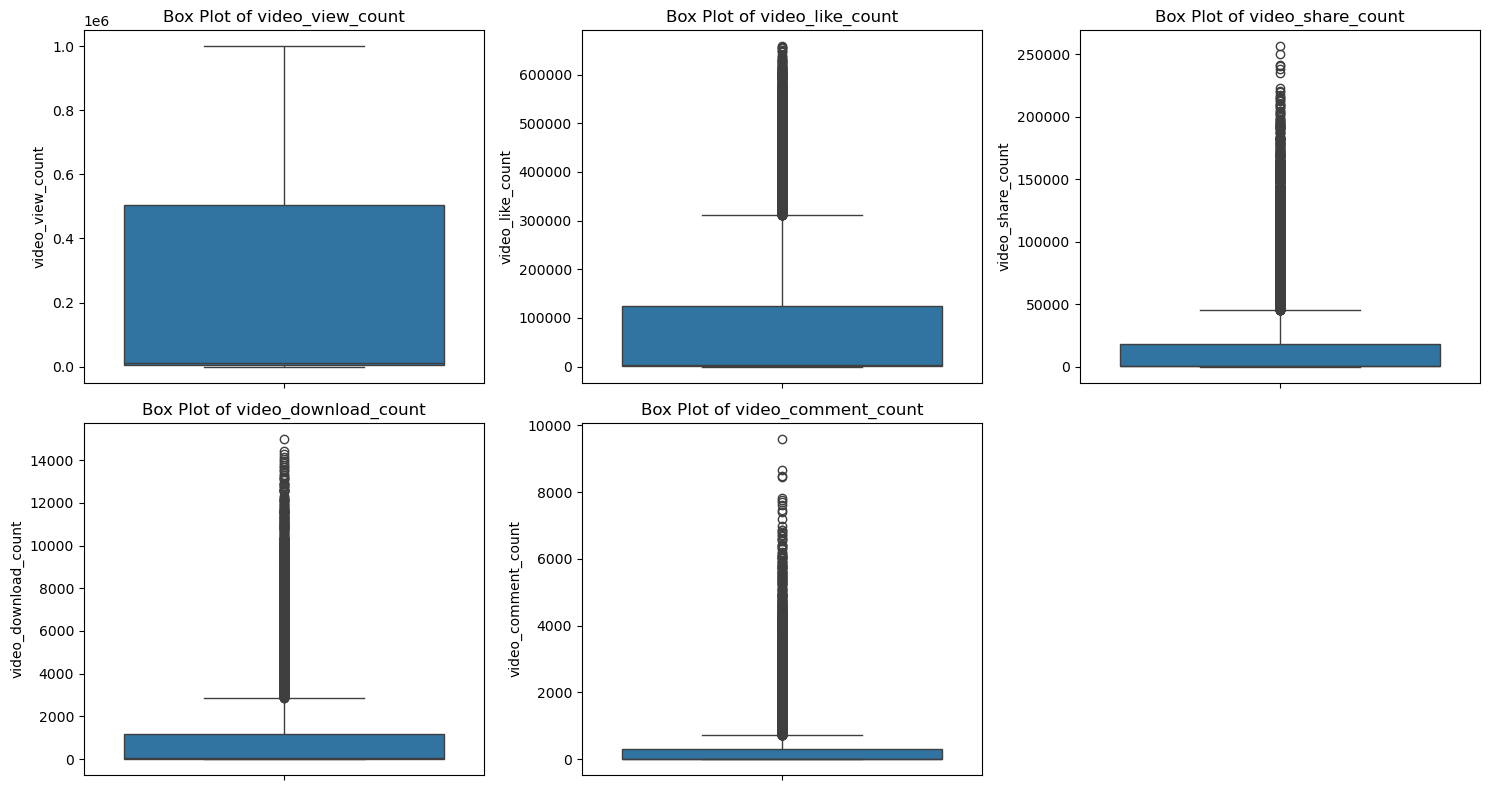

In [20]:
# Box plots for engagement metrics
plt.figure(figsize=(15, 8))

# Plot box plots for key engagement metrics
for i, feature in enumerate(engagement_metrics):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data[feature])
    plt.title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()


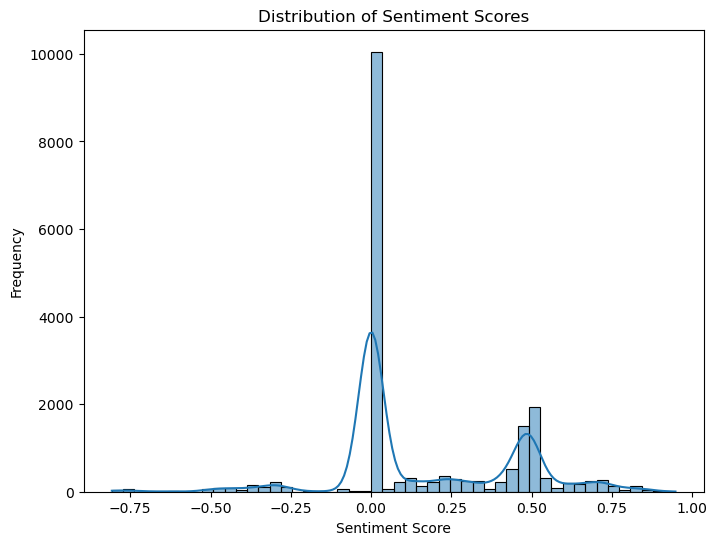

In [21]:
# Distribution of sentiment scores
plt.figure(figsize=(8, 6))
sns.histplot(data['sentiment_score'], kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


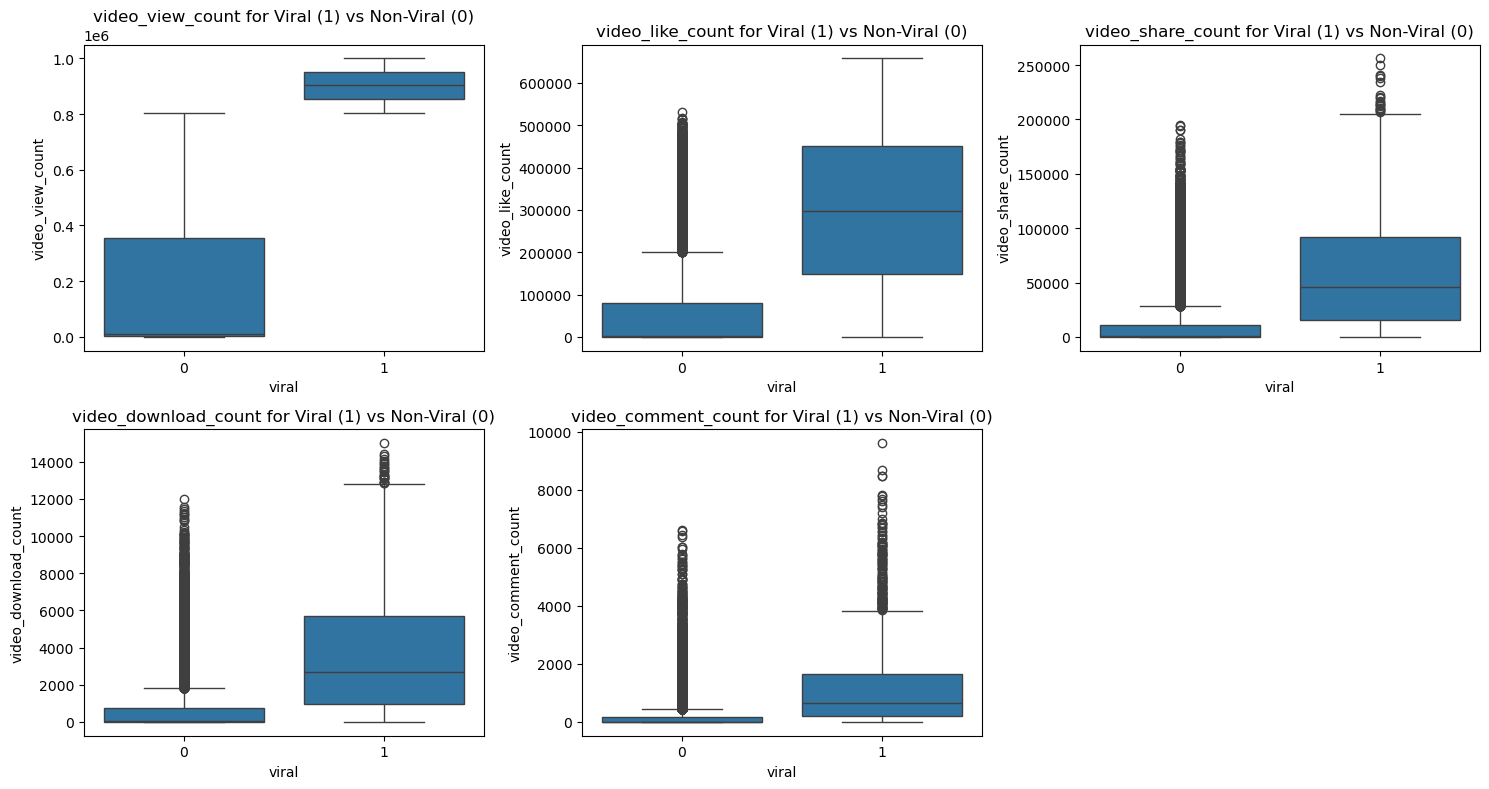

In [22]:
# Define virality as top 10% view count
virality_threshold = data['video_view_count'].quantile(0.90)
data['viral'] = (data['video_view_count'] >= virality_threshold).astype(int)

# Box plot of engagement metrics for viral vs non-viral videos
plt.figure(figsize=(15, 8))

for i, feature in enumerate(engagement_metrics):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='viral', y=feature, data=data)
    plt.title(f'{feature} for Viral (1) vs Non-Viral (0)')

plt.tight_layout()
plt.show()


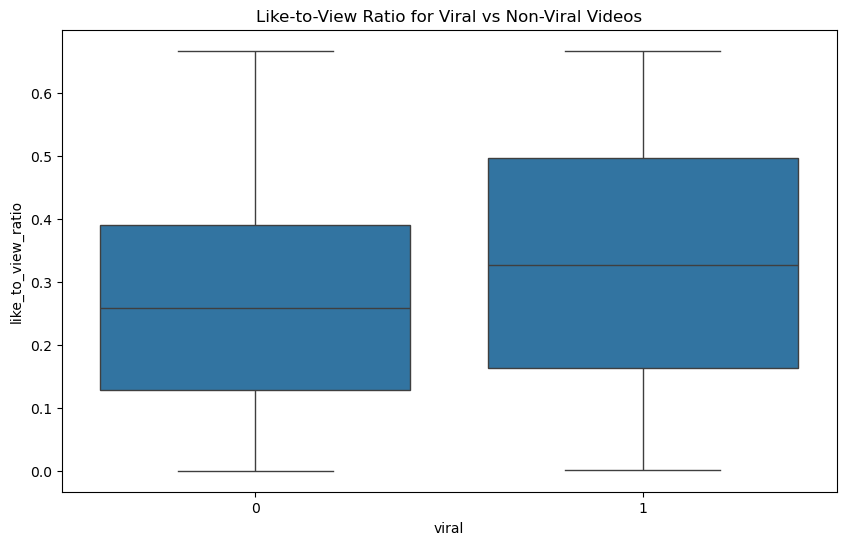

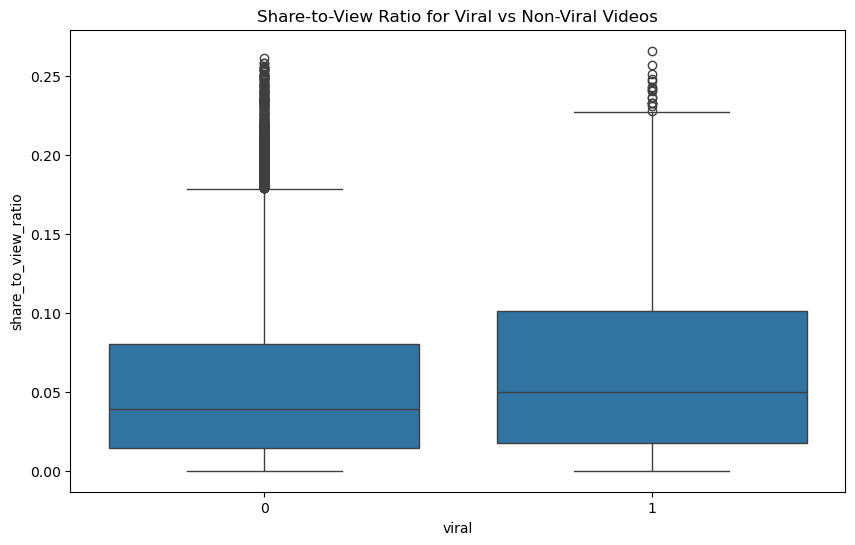

In [23]:
# Engagement ratios box plot for viral vs non-viral videos
plt.figure(figsize=(10, 6))

# Like-to-View ratio vs virality
sns.boxplot(x='viral', y='like_to_view_ratio', data=data)
plt.title('Like-to-View Ratio for Viral vs Non-Viral Videos')
plt.show()

# Share-to-View ratio vs virality
plt.figure(figsize=(10, 6))
sns.boxplot(x='viral', y='share_to_view_ratio', data=data)
plt.title('Share-to-View Ratio for Viral vs Non-Viral Videos')
plt.show()


In [24]:
#model building
# x=input y=output

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Define the viral threshold as the top 10% of views
virality_threshold = data['video_view_count'].quantile(0.90)
data['viral'] = (data['video_view_count'] >= virality_threshold).astype(int)

# Define churn as the bottom 25% of video view counts
churn_threshold = data['video_view_count'].quantile(0.25)
data['churn'] = (data['video_view_count'] < churn_threshold).astype(int)

# Exclude non-relevant columns for modeling
X_viral = data.drop(['video_id', 'video_view_count', 'viral'], axis=1)
y_viral = data['viral']

X_churn = data.drop(['video_id', 'video_view_count', 'churn'], axis=1)
y_churn = data['churn']


In [25]:
# Train-test split for viral video prediction
X_train_viral, X_test_viral, y_train_viral, y_test_viral = train_test_split(X_viral, y_viral, test_size=0.2, random_state=42)

# Train-test split for churn prediction
X_train_churn, X_test_churn, y_train_churn, y_test_churn = train_test_split(X_churn, y_churn, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()

# Select only numerical features for scaling
numerical_features = X_train_viral.select_dtypes(include=['number']).columns
X_train_viral_scaled = scaler.fit_transform(X_train_viral[numerical_features])
X_test_viral_scaled = scaler.transform(X_test_viral[numerical_features])

numerical_features = X_train_churn.select_dtypes(include=['number']).columns
X_train_churn_scaled = scaler.fit_transform(X_train_churn[numerical_features])
X_test_churn_scaled = scaler.transform(X_test_churn[numerical_features])

In [26]:
# Train Logistic Regression for viral prediction
lr_viral = LogisticRegression(max_iter=1000)
lr_viral.fit(X_train_viral_scaled, y_train_viral)

# Train Logistic Regression for churn prediction
lr_churn = LogisticRegression(max_iter=1000)
lr_churn.fit(X_train_churn_scaled, y_train_churn)


LogisticRegression(max_iter=1000)

In [27]:
# Train Random Forest for viral prediction
rf_viral = RandomForestClassifier(n_estimators=200, random_state=42)
rf_viral.fit(X_train_viral_scaled, y_train_viral)

# Train Random Forest for churn prediction
rf_churn = RandomForestClassifier(n_estimators=200, random_state=42)
rf_churn.fit(X_train_churn_scaled, y_train_churn)


RandomForestClassifier(n_estimators=200, random_state=42)

### Model Evaluation

In [29]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Logistic Regression evaluation for virality
y_pred_proba_lr_viral = lr_viral.predict_proba(X_test_viral_scaled)[:, 1]
auc_lr_viral = roc_auc_score(y_test_viral, y_pred_proba_lr_viral)
print(f'Logistic Regression AUC for Viral Prediction: {auc_lr_viral:.2f}')

# Random Forest evaluation for virality
y_pred_proba_rf_viral = rf_viral.predict_proba(X_test_viral_scaled)[:, 1]
auc_rf_viral = roc_auc_score(y_test_viral, y_pred_proba_rf_viral)
print(f'Random Forest AUC for Viral Prediction: {auc_rf_viral:.2f}')

# Confusion Matrix and Classification Report for Random Forest (Virality)
y_pred_rf_viral = rf_viral.predict(X_test_viral_scaled)
print(classification_report(y_test_viral, y_pred_rf_viral))
conf_matrix_viral = confusion_matrix(y_test_viral, y_pred_rf_viral)
print(f'Confusion Matrix for Viral Prediction:\n{conf_matrix_viral}')


Logistic Regression AUC for Viral Prediction: 1.00
Random Forest AUC for Viral Prediction: 1.00
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3432
           1       0.98      0.83      0.89       385

    accuracy                           0.98      3817
   macro avg       0.98      0.91      0.94      3817
weighted avg       0.98      0.98      0.98      3817

Confusion Matrix for Viral Prediction:
[[3424    8]
 [  67  318]]


In [30]:
# Logistic Regression evaluation for churn(to be deleted) 
y_pred_proba_lr_churn = lr_churn.predict_proba(X_test_churn_scaled)[:, 1]
auc_lr_churn = roc_auc_score(y_test_churn, y_pred_proba_lr_churn)
print(f'Logistic Regression AUC for Churn Prediction: {auc_lr_churn:.2f}')

# Random Forest evaluation for churn
y_pred_proba_rf_churn = rf_churn.predict_proba(X_test_churn_scaled)[:, 1]
auc_rf_churn = roc_auc_score(y_test_churn, y_pred_proba_rf_churn)
print(f'Random Forest AUC for Churn Prediction: {auc_rf_churn:.2f}')

# Confusion Matrix and Classification Report for Random Forest (Churn)
y_pred_rf_churn = rf_churn.predict(X_test_churn_scaled)
print(classification_report(y_test_churn, y_pred_rf_churn))
conf_matrix_churn = confusion_matrix(y_test_churn, y_pred_rf_churn)
print(f'Confusion Matrix for Churn Prediction:\n{conf_matrix_churn}')


Logistic Regression AUC for Churn Prediction: 0.97
Random Forest AUC for Churn Prediction: 1.00
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2872
           1       0.99      0.98      0.98       945

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817

Confusion Matrix for Churn Prediction:
[[2859   13]
 [  23  922]]


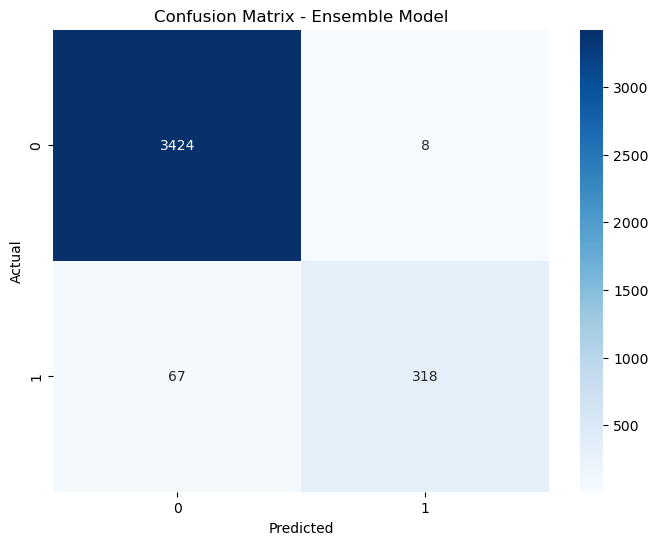

In [31]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))

# Choose the appropriate confusion matrix: conf_matrix_viral or conf_matrix_churn
sns.heatmap(conf_matrix_viral, annot=True, fmt='d', cmap='Blues')

plt.title('Confusion Matrix - Ensemble Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [67]:
import pickle
pickle.dump(lr_viral,open('gpt2.pkl','wb'))